Среднее время ожидания: 0.36
Средняя длина очереди: 0.46
Среднее число агентов: 3
Вероятность потери заявки: 28.62%


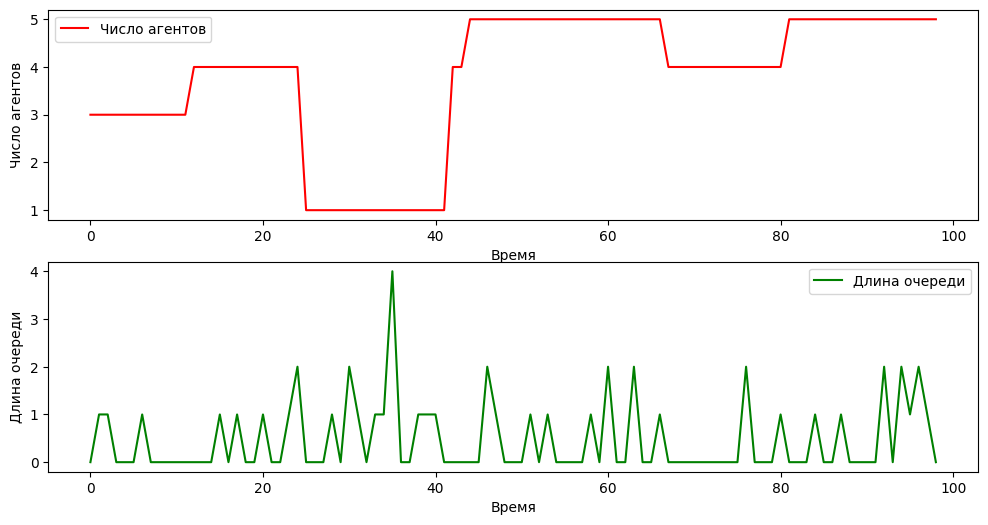

In [11]:
import simpy
import random
import numpy as np
from matplotlib import pyplot as plt

lambda_requests = 10  # интенсивность поступления заявок (заявок/час)
mu_service = 3  # интенсивность обслуживания (заявок/час)
initial_agents = 3  # начальное количество агентов
max_agents = 5  # максимальное количество агентов
agent_connect_rate = 0.1  # вероятность подключения агента (агентов/час)
agent_disconnect_rate = 0.05  # вероятность отключения агента (агентов/час)
sim_time = 1000  # время моделирования (часы)

class CallCenter:
    def __init__(self, env):
        self.env = env
        self.queue = simpy.PriorityResource(env, capacity=initial_agents)  # очередь с приоритетом
        self.active_agents = initial_agents  # начальное количество агентов
        self.total_wait_time = []  # время ожидания для каждой заявки
        self.queue_lengths = []  # длина очереди на каждом шаге
        self.agent_counts = []  # количество агентов на каждом шаге
        self.lost_requests = 0  # количество потерянных заявок

    def process_request(self):
        """Обработка заявки: вычисление времени ожидания и обслуживание."""
        arrival_time = self.env.now
        with self.queue.request(priority=1) as req:
            result = yield req | self.env.timeout(1 / lambda_requests)
            if req in result:
                yield self.env.timeout(1 / mu_service)
                self.total_wait_time.append(self.env.now - arrival_time)  # записываем время ожидания
            else:
                self.lost_requests += 1  # заявка потеряна, так как очередь была переполнена

    def generate_requests(self):
        """Генерация заявок."""
        while True:
            yield self.env.timeout(random.expovariate(lambda_requests))
            self.env.process(self.process_request())

    def manage_agents(self):
        """Управление динамикой агентов (подключение и отключение)."""
        while True:
            yield self.env.timeout(10)  # проверяем состояние агентов каждые 10 часов
            rand_agent = random.randint(1, 3)

            # Подключение агентов
            if random.random() < agent_connect_rate and self.active_agents < max_agents:
                if rand_agent + self.active_agents > max_agents:
                    rand_agent = max_agents - self.active_agents  # не превышать максимальное количество агентов
                self.active_agents += rand_agent
                self.servers = simpy.Resource(self.env, capacity=self.active_agents)

            # Отключение агентов
            if random.random() < agent_disconnect_rate and self.active_agents > 1:
                if self.active_agents - rand_agent < 1:
                    rand_agent = self.active_agents - 1  # не меньше 1 агента
                self.active_agents -= rand_agent
                self.servers = simpy.Resource(self.env, capacity=self.active_agents)

            self.agent_counts.append(self.active_agents)  # фиксируем количество агентов

    def monitor(self):
        """Мониторинг состояния очереди."""
        while True:
            yield self.env.timeout(10)
            self.queue_lengths.append(len(self.queue.queue))  # фиксируем длину очереди

# Создание и запуск симуляции
env = simpy.Environment()
call_center = CallCenter(env)
env.process(call_center.generate_requests())  # процесс генерации заявок
env.process(call_center.manage_agents())  # процесс управления агентами
env.process(call_center.monitor())  # процесс мониторинга очереди

# Запуск симуляции
env.run(until=sim_time)

# Расчет и вывод результатов
average_wait_time = np.mean(call_center.total_wait_time)
average_queue_length = np.mean(call_center.queue_lengths)
average_agents = np.mean(call_center.agent_counts)
loss_probability = call_center.lost_requests / (len(call_center.total_wait_time) + call_center.lost_requests)

def print_res():
    print(f'Среднее время ожидания: {average_wait_time:.2f}')
    print(f'Средняя длина очереди: {average_queue_length:.2f}')
    print(f'Среднее число агентов: {int(average_agents)}')
    print(f'Вероятность потери заявки: {loss_probability:.2%}')

print_res()

def show_plot():
    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(call_center.agent_counts, label='Число агентов', color='red')
    plt.xlabel('Время')
    plt.ylabel('Число агентов')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(call_center.queue_lengths, label='Длина очереди', color='green')
    plt.xlabel('Время')
    plt.ylabel('Длина очереди')
    plt.legend()

    plt.show()

show_plot()
